## Verification
This notebook serves as a proof-of-concept for the proposed inference technique (i.e. hybrid message passing) in autoregressive models.
We showcase the convergence of free energy for two types of latent autoregressive models: (1) stationary autoregressive models and its (2) time-varying counterpart.

(1)
\begin{align}  &\mathbf{x}_t = A(\theta)\mathbf{x}_{t-1} + \mathbf{c}v_{t} \\ &y_t = \mathbf{c}^{\top} \mathbf{x}_{t} + w_t \end{align} 

(2)
\begin{align}  &\boldsymbol{\theta}_t = \boldsymbol{\theta}_{t-1} + \mathbf{v}^{\theta}_{t} \\ &\mathbf{x}_t = A(\boldsymbol{\theta}_t)\mathbf{x}_{t-1} + \mathbf{c}v_{t} \\ &y_t = \mathbf{c}^{\top} \mathbf{x}_{t} + w_t \end{align} 

where
\begin{align} &\mathbf{v}^{\theta}_t \sim \mathcal{MN}(\mathbf{0}, \mathbf{I}) \\ &v_t \sim \mathcal{N}(0, \gamma^{-1}) \\ &w_t \sim \mathcal{N}(0, \tau^{-1}) \end{align}

For each class of the models we synthesized 100 datasets (2x100 datasets) with 100 points per set. The orders $M$ of the generated AR processes are uniformly distributed $M \in (1, 2 ... 10)$, i.e. 10 datasets per order.

In [8]:
include("helpers.jl")
using LinearAlgebra
using LaTeXStrings

# Stationary Autoregressive Models (MP)

In [26]:
# stationary data case
include("data/verification/verification_set.jl")
process_set = beautify_process(ar_data_process) # hidden state dataset
observations_set = ar_data_observations # observations dataset
coefs_set = ar_coefs_set; # coefficients dataset

In [27]:
sorted_stuff = sort(collect(zip(process_set, observations_set, coefs_set)), lt = (left, right) -> left < right, by = (x) -> length(x[1][1])); # sorting datasets in ascending order of M

In [28]:
process_set, observations_set, coefs_set = unzip(sorted_stuff, 1), unzip(sorted_stuff, 2), unzip(sorted_stuff, 3);

In [20]:
save("data/verification/sdata.jld", "process_set", process_set, "observations_set", observations_set, "coefs_set", coefs_set)

In [18]:
using ForneyLab
using ForneyLab: unsafeMean, unsafeCov, unsafePrecision, unsafeMeanCov
using LAR
using LAR.Node
using ProgressMeter


vmp_its = 10 # number of VMP iterations

sfe = zeros(n_dataset, vmp_its) # storage for FE

smx_set = [] # storage for the mean of estimated state
svx_set = [] # storage for the variance of estimated state

smθ_set = [] # storage for the mean of estimated coefs
svθ_set = [] # storage for the variance of estimated coefs

sγx_set = [] # storage for the estimated precision

@showprogress "MP " for n in 1:n_dataset
    ARorder = length(coefs_set[n]) # define the ARorder
    
    # Building graph and algorithm
    if n == 1 || ARorder != length(coefs_set[n-1])

        fg = FactorGraph()

        # State prior
        @RV x_0 ~ GaussianMeanVariance(placeholder(:m_x_0, dims=(ARorder, )),
                                       placeholder(:v_x_0, dims=(ARorder, ARorder)))

        @RV θ ~ GaussianMeanVariance(placeholder(:m_θ, dims=(ARorder, )),
                                     placeholder(:v_θ, dims=(ARorder, ARorder)))

        @RV γ_x ~ ForneyLab.Gamma(placeholder(:a_x), placeholder(:b_x))


        # Transition and observation model
        x = Vector{Variable}(undef, n_samples)
        y = Vector{Variable}(undef, n_samples)

        c = zeros(ARorder); c[1] = 1.0

        x_i_min = x_0
        for i in 1:n_samples
            @RV x[i] ~ Autoregressive(θ, x_i_min, γ_x)

            @RV y[i] ~ GaussianMeanPrecision(dot(c, x[i]), 1.0)

            # Data placeholder
            placeholder(y[i], :y, index=i)

            # Reset state for next step
            x_i_min = x[i]
        end

        q = PosteriorFactorization(x_0, x, γ_x, θ, ids=[:X0 :X :ΓX :Θ])
        algo = messagePassingAlgorithm(free_energy=true)
        src_code = algorithmSourceCode(algo, free_energy=true)
        eval(Meta.parse(src_code))
        
    end
    
    # Defining priors and observations
    data = Dict(:y => observations_set[n], :m_x_0 => zeros(ARorder), :v_x_0 => huge*diagm(ones(ARorder)),
                :m_θ => 0.5 .* ones(ARorder), :v_θ => huge*diagm(ones(ARorder)),
                :a_x => tiny, :b_x => 1.0)

    # Initial posterior factors
    marginals = Dict{Symbol, ProbabilityDistribution}()
    marginals[:θ] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=zeros(ARorder), v=diagm(ones(ARorder)))
    marginals[:γ_x] = ProbabilityDistribution(ForneyLab.Gamma, a=1.0, b=1.0)
    for i in 0:n_samples
        marginals[:x_*i] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=zeros(ARorder), v=diagm(ones(ARorder)))
    end
    
    # Run algorithm
    for i in 1:vmp_its
        stepX0!(data, marginals)
        stepX!(data, marginals)
        stepΓX!(data, marginals)
        stepΘ!(data, marginals)
        sfe[n, i] = freeEnergy(data, marginals)
    end
    
    # Collect estimations
    push!(smx_set, [unsafeMean(marginals[Symbol("x_$(i)_x_$(i-1)")])[1] for i in 2:length(observations_set[n])])
    push!(svx_set, [unsafeCov(marginals[Symbol("x_$(i)_x_$(i-1)")])[1] for i in 2:length(observations_set[n])])
    insert!(smx_set[n], 1, unsafeMean(marginals[Symbol("x_1")])[1])
    insert!(svx_set[n], 1, unsafeCov(marginals[Symbol("x_1")])[1])
    
    push!(smθ_set, unsafeMean(marginals[:θ]))
    push!(svθ_set, unsafeCov(marginals[:θ]))
            
    push!(sγx_set, unsafeMean(marginals[:γ_x]))

end



MP 100%|████████████████████████████████████████████████| Time: 0:11:06


In [19]:
# Saving
using JLD
save("data/verification/svmp.jld", "smx_set", smx_set, "svx_set", svx_set, "smθ_set", smθ_set, "svθ_set", svθ_set, "sγx_set", sγx_set, "sfe", sfe)

In [16]:
# Loading
using ForneyLab
using ForneyLab: unsafeMean, unsafeCov, unsafePrecision, unsafeMeanCov
using LAR
using LAR.Node
using ProgressMeter
using JLD

d = load("data/verification/svmp.jld")
sfe = d["sfe"]
smx_set = d["smx_set"]
svx_set = d["svx_set"]
smθ_set = d["smθ_set"]
svθ_set = d["svθ_set"]
sγx_set = d["sγx_set"];

In [31]:
index = 99 # dataset index
using Plots
scatter(observations_set[index], markershape = :xcross, markeralpha = 0.6, markersize = 2, label="observation")
plot!(smx_set[index], ribbon=sqrt.(svx_set[index]), label="inferred", linestyle=:dash, linewidth = 2, color=:black, fillalpha = 0.2, fillcolor = :black)
plot!(process_set[index], color=:magenta, label="real", xlabel="time t", ylabel="value", title="AR(10)")
#savefig("figures/stat_verification_estimation.pdf")

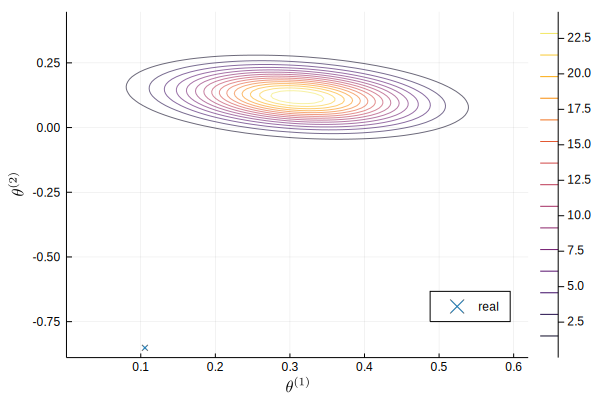

In [24]:
# to plot the following figure, the index should be set in range 11..12
index = index
xs = coefs_set[index]
xs = hcat(xs...)
path_x = []
path_y = []
plot()
scatter!([xs[1]], [xs[2]], markershape = :xcross, markeralpha = 0.6, markersize = 2, label="real")
plot!(legend=:bottomright, xlabel=L"\theta^{(1)}", ylabel=L"\theta^{(2)}")

len = 64
# 1. Definition of the bivariate gaussian using a covariance matrix
𝓝(x, μ, Σ) = 1/((2 * π)^(length(μ)/2) * det(Σ)^(1/2)) *
    exp(-(1/2) * (x-μ)' * Σ^(-1) * (x-μ))

mtheta_end = smθ_set[index]
vtheta_end = svθ_set[index]

# get the maximum σ (used to construct the x and y ranges)
σ_max = sqrt((vtheta_end[1] > vtheta_end[4] ) ? vtheta_end[1] : vtheta_end[4])
rx = range(mtheta_end[1]-3*σ_max, mtheta_end[1]+3*σ_max, length=len)
ry = range(mtheta_end[2]-3*σ_max, mtheta_end[2]+3*σ_max, length=len)
contour!(rx, ry, (x1, x2) -> 𝓝([x1 ; x2], mtheta_end, vtheta_end))
plot!()

In [12]:
# Arithmetic mean
FE = sum(sfe, dims=1) ./ n_dataset

1×10 Array{Float64,2}:
 603.236  457.492  440.22  438.882  …  437.687  437.561  437.476  437.417

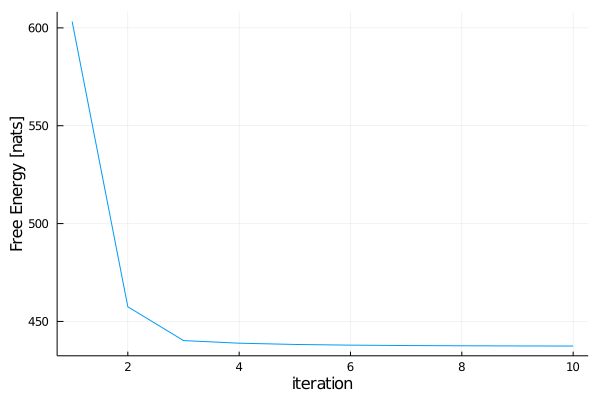

In [14]:
plot(FE', legend=false, xlabel="iteration", ylabel="Free Energy [nats]")
#savefig("figures/stat_free_energy_verification.pdf")

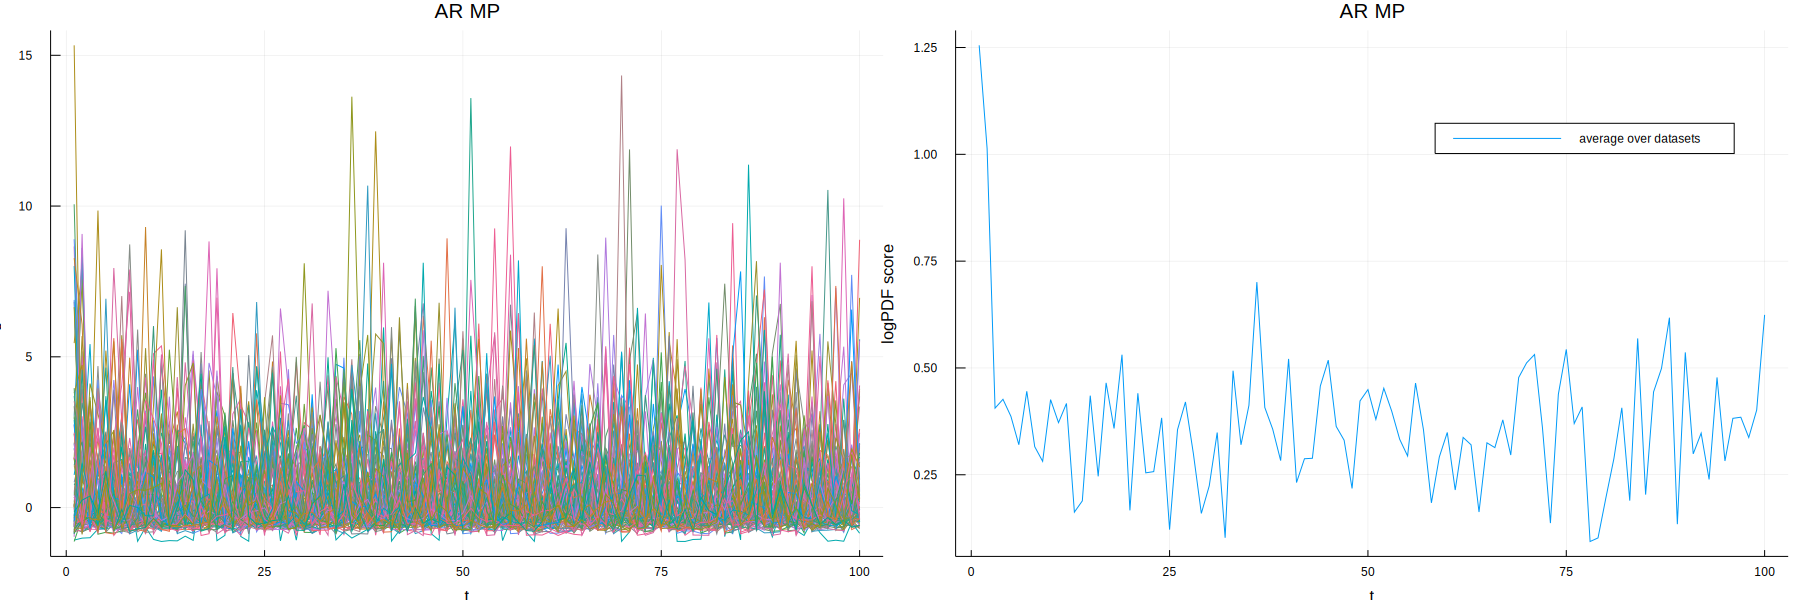

In [30]:
plot()
for i in 1:n_dataset
    plot!(logPDF.(smx_set[i], process_set[i], svx_set[i]), legend=:false, ylabel="logPDF score", xlabel="t")
end
p1 = plot!()
p2 = plot(sum([logPDF.(smx_set[n], process_set[n], svx_set[n]) for n in 1:n_dataset], dims=1)./n_samples, label="average over datasets", ylabel="logPDF score", xlabel="t")
plot(p1, p2, layout = (1, 2), size=(1800, 600), title="AR MP")

In [31]:
# TOTAL logPDFscore
logPDFscore = sum(sum([logPDF.(smx_set[n], process_set[n], svx_set[n]) for n in 1:n_dataset])./n_dataset')/n_samples

0.3673523457715679

# Time Varying Autoregressive Models (MP)

In [36]:
# time_varying data case
include("data/verification/verification_set.jl")
process_set = beautify_process(tvar_data_process)
observations_set = tvar_data_observations
coefs_set = tvar_coefs_set
coefs_var = tvar_var_set;

In [37]:
save("data/verification/tvdata.jld", "process_set", process_set, "observations_set", observations_set, "coefs_set", coefs_set, "coefs_var", coefs_var)

In [38]:
using ForneyLab
using ForneyLab: unsafeMean, unsafeCov, unsafePrecision, unsafeMeanCov
using LAR
using LAR.Node
using LinearAlgebra
using ProgressMeter

vmp_its = 10 # number of VMP iterations

tvfe = zeros(n_dataset, vmp_its) # storage for FE

tvmx_set = [] # storage for the mean of estimated state
tvvx_set = [] # storage for the variance of estimated state

tvmθ_set = [] # storage for the mean of estimated coefs
tvvθ_set = [] # storage for the variance of estimated coefs

tvγx_set = [] # storage for the estimated precision
@showprogress "MP " for n in 1:n_dataset
    ARorder = length(coefs_set[n][1]) # define AR order 
    if n == 1 || ARorder != length(coefs_set[n-1][1])
        fg = FactorGraph()

        # State prior
        @RV x_0 ~ GaussianMeanVariance(placeholder(:m_x_0, dims=(ARorder, )),
                                        placeholder(:v_x_0, dims=(ARorder, ARorder)))

        @RV θ_0 ~ GaussianMeanVariance(placeholder(:m_θ_0, dims=(ARorder, )),
                                        placeholder(:v_θ_0, dims=(ARorder, ARorder)))

        @RV γ_x ~ ForneyLab.Gamma(placeholder(:a_x), placeholder(:b_x))

        # Transition and observation model
        x = Vector{Variable}(undef, n_samples)
        θ = Vector{Variable}(undef, n_samples)
        y = Vector{Variable}(undef, n_samples)

        c = zeros(ARorder); c[1] = 1.0

        x_i_min = x_0
        θ_i_min = θ_0
        for i in 1:n_samples
            @RV θ[i] ~ GaussianMeanPrecision(θ_i_min, 100*diagm(ones(ARorder)))
            @RV x[i] ~ Autoregressive(θ[i], x_i_min, γ_x)

            @RV y[i] ~ GaussianMeanPrecision(dot(c, x[i]), 1.0)

            # Data placeholder
            placeholder(y[i], :y, index=i)

            # Reset state for next step
            x_i_min = x[i]
            θ_i_min = θ[i]
        end

        q = PosteriorFactorization(x_0, x, γ_x, θ_0, θ, ids=[:X0 :X :ΓX :Θ0 :Θ])
        algo = messagePassingAlgorithm(free_energy=true)
        src_code = algorithmSourceCode(algo, free_energy=true)
        eval(Meta.parse(src_code))
    end

    data = Dict(:y => observations_set[n], :m_x_0 => zeros(ARorder), :v_x_0 => huge*diagm(ones(ARorder)),
                :m_θ_0 => 0.5*ones(ARorder), :v_θ_0 => huge*diagm(ones(ARorder)),
                :a_x => tiny, :b_x => 1.0)

    # Initial posterior factors
    marginals = Dict{Symbol, ProbabilityDistribution}()
    marginals[:γ_x] = ProbabilityDistribution(ForneyLab.Gamma, a=1.0, b=1.0)
    for i in 0:n_samples
        marginals[:θ_*i] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=zeros(ARorder), v=diagm(ones(ARorder)))
        marginals[:x_*i] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=zeros(ARorder), v=diagm(ones(ARorder)))
    end
    
    # Run algorithm
    for i in 1:vmp_its
        stepX0!(data, marginals)
        stepX!(data, marginals)
        stepΓX!(data, marginals)
        stepΘ0!(data, marginals)
        stepΘ!(data, marginals)
        tvfe[n, i] = freeEnergy(data, marginals)
    end
    push!(tvmx_set, [unsafeMean(marginals[Symbol("x_$(i)_x_$(i-1)")])[1] for i in 2:length(observations_set[n])])
    push!(tvvx_set, [unsafeCov(marginals[Symbol("x_$(i)_x_$(i-1)")])[1] for i in 2:length(observations_set[n])])
    insert!(tvmx_set[n], 1, unsafeMean(marginals[Symbol("x_1")])[1])
    insert!(tvvx_set[n], 1, unsafeCov(marginals[Symbol("x_1")])[1])

    push!(tvmθ_set, [unsafeMean(marginals[Symbol("θ_$(i)")]) for i in 2:length(observations_set[n])])
    push!(tvvθ_set, [unsafeCov(marginals[Symbol("θ_$(i)")]) for i in 2:length(observations_set[n])])
    insert!(tvmθ_set[n], 1, unsafeMean(marginals[Symbol("θ_1")]))
    insert!(tvvθ_set[n], 1, unsafeCov(marginals[Symbol("θ_1")]))

    push!(tvγx_set, unsafeMean(marginals[:γ_x]))
end

MP 100%|████████████████████████████████████████████████| Time: 0:14:50


In [26]:
using JLD
save("data/verification/tvvmp.jld", "tvmx_set", tvmx_set, "tvvx_set", tvvx_set, "tvmθ_set", tvmθ_set, "tvvθ_set", tvvθ_set, "tvγx_set", tvγx_set, "tvfe", tvfe)

In [27]:
using JLD
using ForneyLab
using ForneyLab: unsafeMean, unsafeCov, unsafePrecision, unsafeMeanCov
using LAR
using LAR.Node
using ProgressMeter
using JLD

d = load("data/verification/tvvmp.jld")
tvfe = d["tvfe"]
tvmx_set = d["tvmx_set"]
tvvx_set = d["tvvx_set"]
tvmθ_set = d["tvmθ_set"]
tvvθ_set = d["tvvθ_set"]
tvγx_set = d["tvγx_set"];

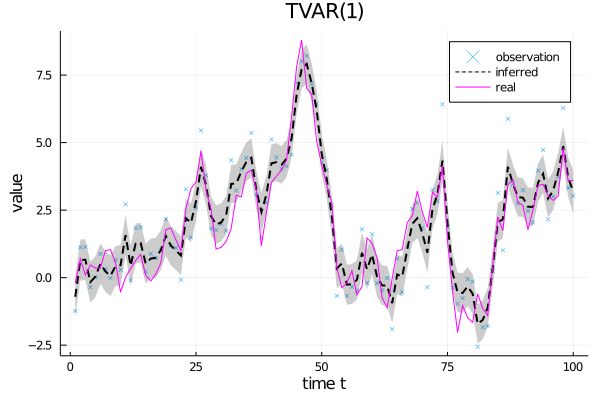

In [53]:
index = 10
using Plots
scatter(observations_set[index], markershape = :xcross, markeralpha = 0.6, markersize = 2, label="observation", xlabel="time t", ylabel="value")
plot!(tvmx_set[index], ribbon=sqrt.(tvvx_set[index]), label="inferred", linestyle=:dash, linewidth = 2, color=:black, fillalpha = 0.2, fillcolor = :black)
plot!(process_set[index], color=:magenta, label="real", title="TVAR(1)")
#savefig("figures/tvar_verification_estimations.pdf")

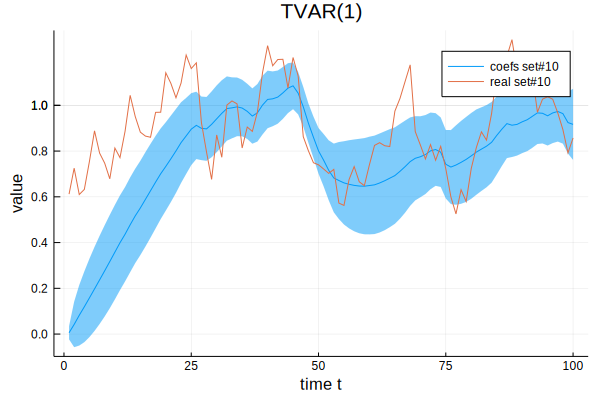

In [39]:
# to plot the following figure, the index should be set in range 1..10
index = 10
for i in 1:n_dataset
    if i == index
        mθ = collect(Iterators.flatten(tvmθ_set[i]))
        vθ = collect(Iterators.flatten(tvvθ_set[i]))
        plot(mθ, ribbon=sqrt.(vθ), label="coefs set#$(i)")
        break
    end
end
real_coefs = collect(Iterators.flatten(coefs_set[index]))
plot!(real_coefs, xlabel="time t", ylabel="value", label="real set#$(index)", title="TVAR(1)")
#savefig("figures/coefs_verification_estimation.pdf")

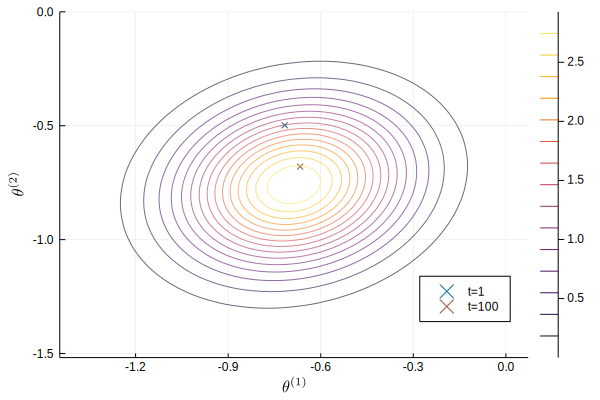

In [71]:
# to plot the following figure, the index should be set in range 1..10
index = 13
xs = coefs_set[index]
xs = hcat(xs...)
path_x = []
path_y = []
plot()
scatter!([xs[:, 1][1]], [xs[:, 1][2]], markershape = :xcross, markeralpha = 0.6, markersize = 2, label="t=$(1)")
scatter!([xs[:, end][1]], [xs[:, end][2]], markershape = :xcross, markeralpha = 0.6, markersize = 2, label="t=$(100)")
plot!(legend=:bottomright, xlabel=L"\theta^{(1)}", ylabel=L"\theta^{(2)}")

len = 64
# 1. Definition of the bivariate gaussian using a covariance matrix
𝓝(x, μ, Σ) = 1/((2 * π)^(length(μ)/2) * det(Σ)^(1/2)) *
    exp(-(1/2) * (x-μ)' * Σ^(-1) * (x-μ))

mtheta_1 = tvmθ_set[index][1]
vtheta_1 = tvvθ_set[index][1]
mtheta_end = tvmθ_set[index][end]
vtheta_end = tvvθ_set[index][end]

# get the maximum σ (used to construct the x and y ranges)
σ_max = sqrt((vtheta_end[1] > vtheta_end[4] ) ? vtheta_end[1] : vtheta_end[4])
rx = range(mtheta_end[1]-3*σ_max, mtheta_end[1]+3*σ_max, length=len)
ry = range(mtheta_end[2]-3*σ_max, mtheta_end[2]+3*σ_max, length=len)
#contour!(rx, ry, (x1, x2) -> 𝓝([x1 ; x2], mtheta_1, vtheta_1))
contour!(rx, ry, (x1, x2) -> 𝓝([x1 ; x2], mtheta_end, vtheta_end))
plot!()

In [51]:
# TOTAL logPDFscore
logPDFscore = sum(sum([logPDF.(tvmx_set[n], process_set[n], tvvx_set[n]) for n in 1:n_dataset])./n_dataset')/n_samples

0.5341429163845131

In [131]:
# Arithmetic mean
FE = sum(tvfe, dims=1) ./ n_dataset

1×10 Array{Float64,2}:
 627.711  490.57  466.646  464.354  …  463.097  462.941  462.826  462.736

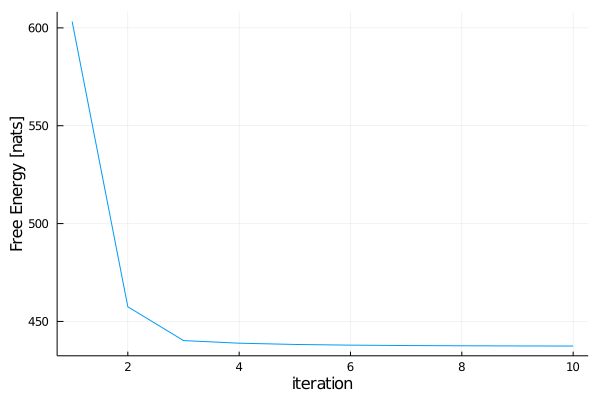

In [47]:
plot(FE', legend=false, xlabel="iteration", ylabel="Free Energy [nats]")
#savefig("figures/tvar_free_energy_verification.pdf")

## NOTE: Sampling will be dropped from the paper

# Sampling stationary AR

In [428]:
# stationary data case
include("data/verification/verification_set.jl")
process_set = beautify_process(ar_data_process)
observations_set = ar_data_observations
coefs_set = ar_coefs_set;

In [429]:
using Turing

@model AR(y, order) = begin
    n_samples = length(y)
    x = Vector(undef, n_samples + order)
    θ ~ MvNormal(zeros(order), 1)
    σ² ~ InverseGamma(1.0, 1.0)

    for t in 1:order
        x[t] ~ Normal(0, 1.0)
    end

    for t in order+1:n_samples+order
        val = θ'reverse!(x[t-order:t-1])
        x[t] ~ Normal(val, σ²)
        y[t-order] ~ Normal(x[t], 1.0)

    end
end

(::DynamicPPL.ModelGen{(:y, :order),var"###AR#978",NamedTuple{(),Tuple{}}}) (generic function with 1 method)

In [430]:
using Logging
using ProgressMeter
disable_logging(Base.CoreLogging.Warn)

Random.seed!(42)

t_smx_set = []
t_svx_set = []

t_smθ_set = []
t_svθ_set = []

t_smσ_set = []

@showprogress "Samping " for n in 1:n_dataset
    ARorder = length(coefs_set[n])

    chn = sample(AR(observations_set[n], ARorder),  PG(20), 1000, progress=false)
    #chn = sample(AR(observations_set[n], ARorder),  NUTS(0.7), 100, progress=false)
    #chn = sample(AR(observations_set[n], ARorder),  HMC(0.05, 10), 100, progress=false)

    samples = get(chn, :x)
    mx = [mean(samples.x[i].data) for i in 1:n_samples]
    vx = [std(samples.x[i].data) for i in 1:n_samples]

    samples = get(chn, :θ)
    mθ = [mean(samples.θ[i]) for i in 1:ARorder]
    vθ = [std(samples.θ[i]) for i in 1:ARorder]

    samples = get(chn, :σ²)
    mσ² = mean(samples.σ²)
    
    push!(t_smx_set, mx)
    push!(t_svx_set, vx)
    push!(t_smθ_set, mθ)
    push!(t_svθ_set, vθ)
    push!(t_smσ_set, mσ²)
end

Samping 100%|███████████████████████████████████████████| Time: 9:47:07


In [431]:
using JLD
save("dump/t_svmp.jld", "t_smx_set", t_smx_set, "t_svx_set", t_svx_set, "t_smθ_set", t_smθ_set, "t_svθ_set", t_svθ_set, "t_smσ_set", t_smσ_set)

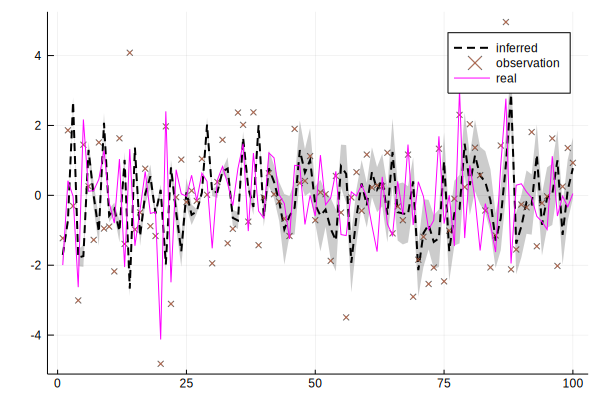

In [432]:
index = 1
using Plots
plot(t_smx_set[index], ribbon=sqrt.(t_svx_set[index]), label="inferred", linestyle=:dash, linewidth = 2, color=:black, fillalpha = 0.2, fillcolor = :black)
scatter!(observations_set[index], markershape = :xcross, markeralpha = 0.6, markersize = 2, label="observation")
plot!(process_set[index], color=:magenta, label="real")

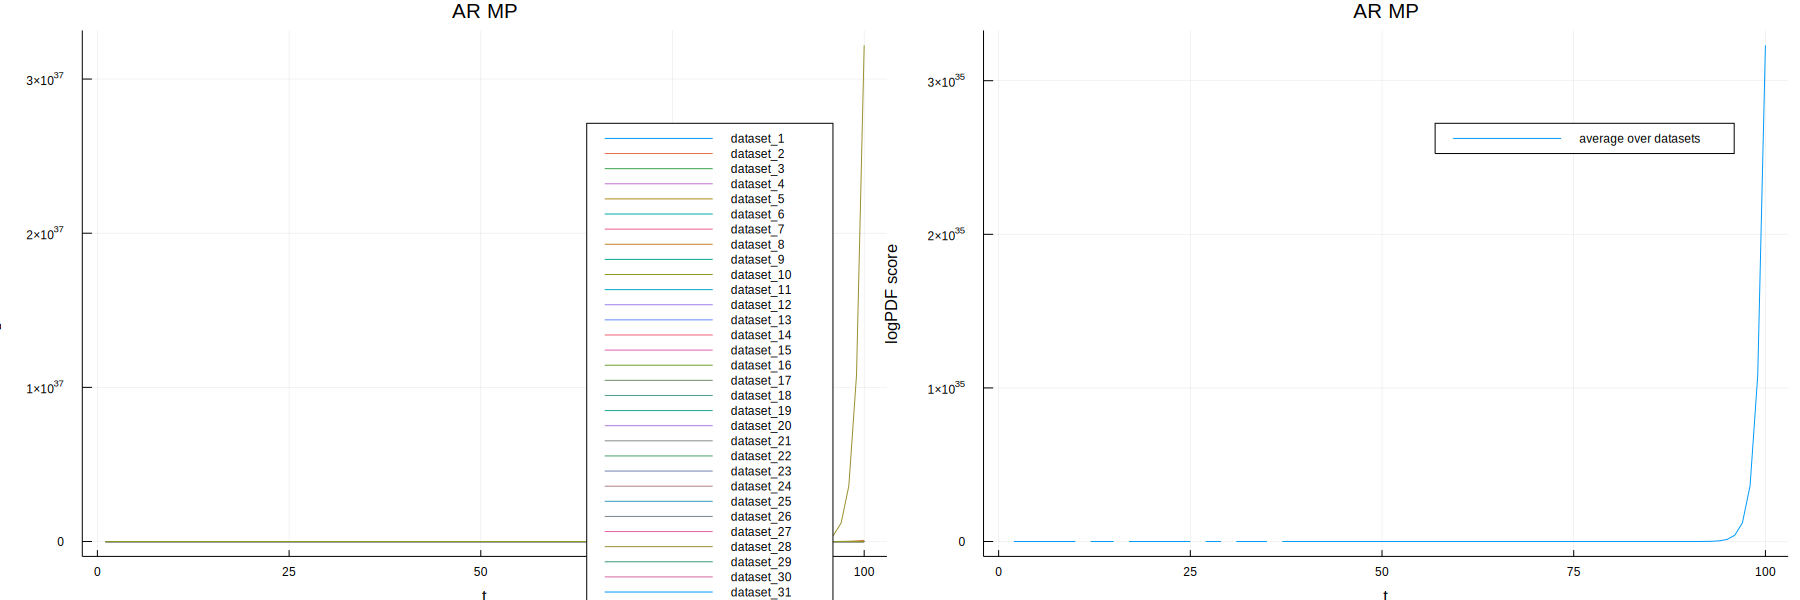

In [433]:
plot()
for i in 1:n_dataset
    plot!(logPDF.(t_smx_set[i], process_set[i], t_svx_set[i]), label="dataset_$(i)", ylabel="logPDF score", xlabel="t")
end
p1 = plot!()
p2 = plot(sum([logPDF.(t_smx_set[n], process_set[n], t_svx_set[n]) for n in 1:n_dataset], dims=1)./n_samples, label="average over datasets", ylabel="logPDF score", xlabel="t")
plot(p1, p2, layout = (1, 2), size=(1800, 600), title="AR MP")

In [434]:
# TOTAL logPDFscore
logPDFscore = sum(sum([logPDF.(t_smx_set[n], process_set[n], t_svx_set[n]) for n in 1:n_dataset])./n_dataset')/n_samples

NaN

# HMC TVAR

In [435]:
# time_varying data case
include("data/verification/verification_set.jl")
process_set = beautify_process(tvar_data_process)
observations_set = tvar_data_observations
coefs_set = tvar_coefs_set
coefs_var = tvar_var_set;

In [436]:
coefs_set[1]

100-element Array{Array{Float64,1},1}:
 [-0.4439607223627549]
 [-0.4663742688461898]
 [-0.4649683968940926]
 [-0.4643931130429438]
 [-0.4697879464633408]
 [-0.47341376149253994]
 [-0.4708052170656712]
 [-0.4884146724576261]
 [-0.47810906515827617]
 [-0.47312642024496626]
 [-0.4719716730424338]
 [-0.48545253141897254]
 [-0.4776247262431172]
 ⋮
 [-0.4722321792412683]
 [-0.4824459441341668]
 [-0.493058815369044]
 [-0.506233972390315]
 [-0.5139071056094765]
 [-0.5133731842931102]
 [-0.5172656697343672]
 [-0.5277180204811169]
 [-0.5394712059994314]
 [-0.5494664169020256]
 [-0.5601701725766304]
 [-0.572874430090696]

In [437]:
using Turing

@model TVAR(y, order) = begin
    n_samples = length(y)
    x = Vector(undef, n_samples + order)
    θ = Vector(undef, n_samples + 1.0)
    σ² ~ InverseGamma(1, 10)
    θ[1] ~ MvNormal(zeros(order), 1.0)

    for t in 1:order
        x[t] ~ Normal(0, 1.0)
    end
    for t in order+1:n_samples+order
        θ[t-order+1] ~ MvNormal(θ[t-order], 0.01)
        val = θ[t-order+1]'reverse!(x[t-order:t-1])
        x[t] ~ Normal(val, σ²)
        y[t-order] ~ Normal(x[t], 1.0)

    end
end

(::DynamicPPL.ModelGen{(:y, :order),var"###TVAR#1039",NamedTuple{(),Tuple{}}}) (generic function with 1 method)

In [438]:
using Logging
disable_logging(Base.CoreLogging.Warn)
using ProgressMeter

Random.seed!(42)

t_tvmx_set = []
t_tvvx_set = []

t_tvmθ_set = []
t_tvvθ_set = []

t_tvmσ_set = []

@showprogress "Samping " for n in 1:n_dataset
    order = length(coefs_set[n][1])

    chn = sample(TVAR(observations_set[n], order),  PG(20), 1000, progress=false)
    #chn = sample(TVAR(observations_set[n], order),   NUTS(0.7), 100, progress=false)
    #chn = sample(TVAR(observations_set[n], ARorder),  HMC(0.05, 10), 100, progress=false)

    samples = get(chn, :x)
    mx = [mean(samples.x[i].data) for i in 1:n_samples]
    vx = [std(samples.x[i].data) for i in 1:n_samples]

    samples = get(chn, :θ)
    
    mθ_tmp = [mean(samples.θ[i].data) for i in 1:n_samples*order]
    vθ_tmp = [std(samples.θ[i].data) for i in 1:n_samples*order]
    mθ = [mθ_tmp[i:i+order-1] for i in 1:order:n_samples*order-order+1]
    vθ = [vθ_tmp[i:i+order-1] for i in 1:order:n_samples*order-order+1]

    samples = get(chn, :σ²)
    mσ² = mean(samples.σ²)
    
    push!(t_tvmx_set, mx)
    push!(t_tvvx_set, vx)
    push!(t_tvmθ_set, mθ)
    push!(t_tvvθ_set, vθ)
    push!(t_tvmσ_set, mσ²)
    
end

Samping 100%|███████████████████████████████████████████| Time: 1 days, 2:08:33


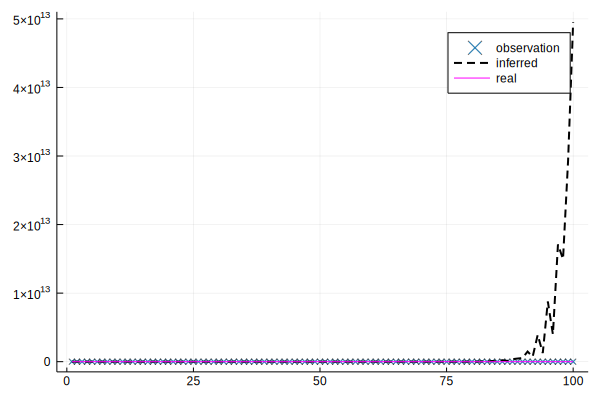

In [446]:
index = 65
using Plots
scatter(observations_set[index], markershape = :xcross, markeralpha = 0.6, markersize = 2, label="observation")
plot!(t_tvmx_set[index], ribbon=sqrt.(t_tvvx_set[index]), label="inferred", linestyle=:dash, linewidth = 2, color=:black, fillalpha = 0.2, fillcolor = :black)
plot!(process_set[index], color=:magenta, label="real")

In [440]:
using JLD
save("data/verification/t_tvvmp.jld", "t_tvmx_set", t_tvmx_set, "t_tvvx_set", t_tvvx_set, "t_tvmθ_set", t_tvmθ_set, "t_tvvθ_set", t_tvvθ_set, "t_tvmσ_set", t_tvmσ_set)

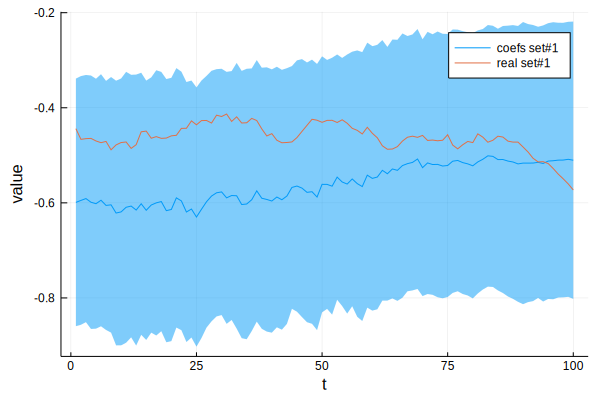

In [441]:
index = 0
for i in 1:n_dataset
    if length(t_tvmθ_set[i][1]) == 1
        index = i
        mθ = collect(Iterators.flatten(t_tvmθ_set[i]))
        vθ = collect(Iterators.flatten(t_tvvθ_set[i]))
        plot(mθ, ribbon=sqrt.(vθ), label="coefs set#$(i)")
        break
    end
end
if index > 0
    real_coefs = collect(Iterators.flatten(coefs_set[index]))
    plot!(real_coefs, xlabel="t", ylabel="value", label="real set#$(index)")
else
    plot()
end

In [442]:
coefs_set[index]

100-element Array{Array{Float64,1},1}:
 [-0.4439607223627549]
 [-0.4663742688461898]
 [-0.4649683968940926]
 [-0.4643931130429438]
 [-0.4697879464633408]
 [-0.47341376149253994]
 [-0.4708052170656712]
 [-0.4884146724576261]
 [-0.47810906515827617]
 [-0.47312642024496626]
 [-0.4719716730424338]
 [-0.48545253141897254]
 [-0.4776247262431172]
 ⋮
 [-0.4722321792412683]
 [-0.4824459441341668]
 [-0.493058815369044]
 [-0.506233972390315]
 [-0.5139071056094765]
 [-0.5133731842931102]
 [-0.5172656697343672]
 [-0.5277180204811169]
 [-0.5394712059994314]
 [-0.5494664169020256]
 [-0.5601701725766304]
 [-0.572874430090696]

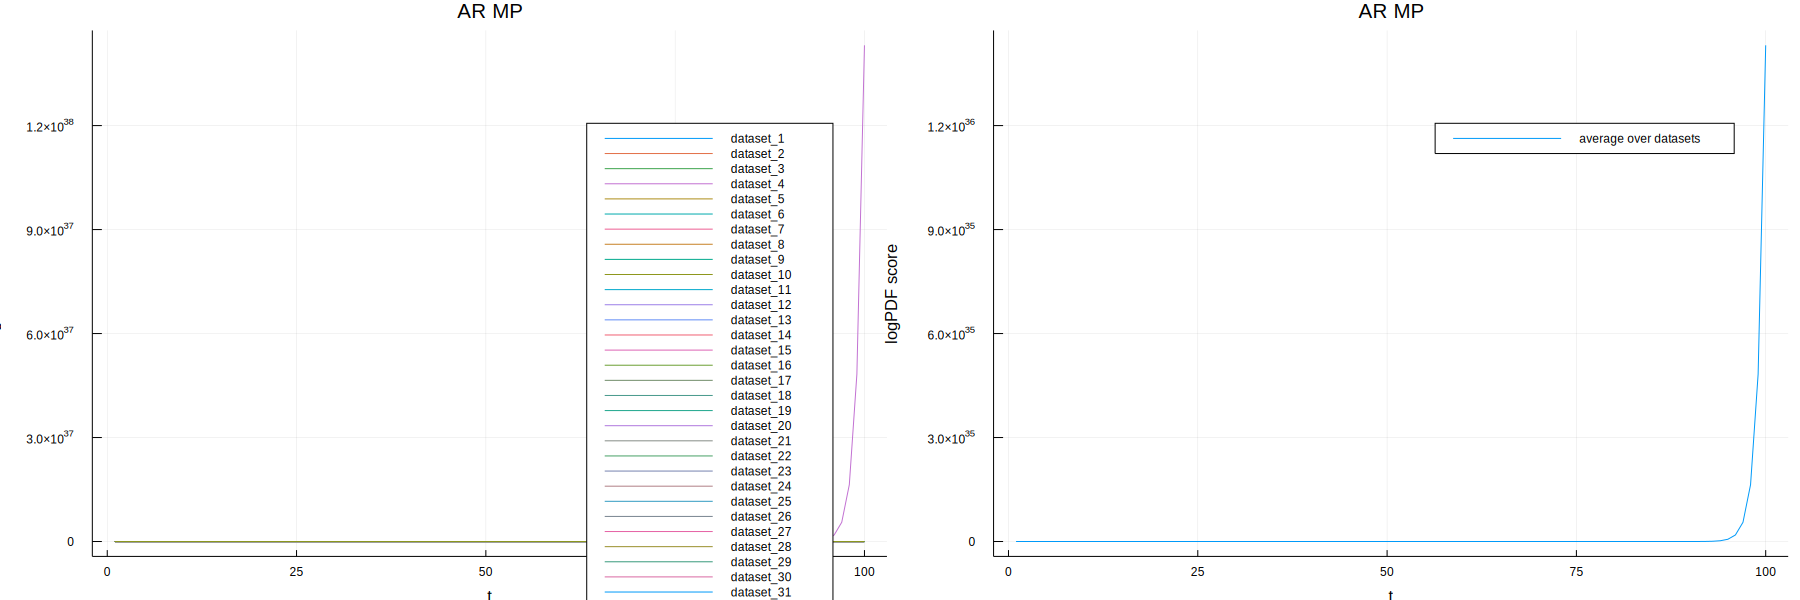

In [443]:
plot()
for i in 1:n_dataset
    plot!(logPDF.(t_tvmx_set[i], process_set[i], t_tvvx_set[i]), label="dataset_$(i)", ylabel="logPDF score", xlabel="t")
end
p1 = plot!()
p2 = plot(sum([logPDF.(t_tvmx_set[n], process_set[n], t_tvvx_set[n]) for n in 1:n_dataset])./n_dataset', label="average over datasets", ylabel="logPDF score", xlabel="t")
plot(p1, p2, layout = (1, 2), size=(1800, 600), title="AR MP")

In [444]:
# TOTAL logPDFscore
logPDFscore = sum(sum([logPDF.(t_tvmx_set[n], process_set[n], t_tvvx_set[n]) for n in 1:n_dataset])./n_dataset')/n_samples

2.16275926923118e34

# FEAR analysis

In [3]:
using Plots

In [47]:
# Stationary AR
counter = 0
for i in 1:size(sfe, 1)
    for j in 2:length(sfe[i, :])
        if sfe[i, j] - sfe[i, j-1] > 1.0
            println("Example #$(i), AR_m = $(length(smθ_set[i]))")
            counter += 1
            break
        end
    end
end
println(counter)

0


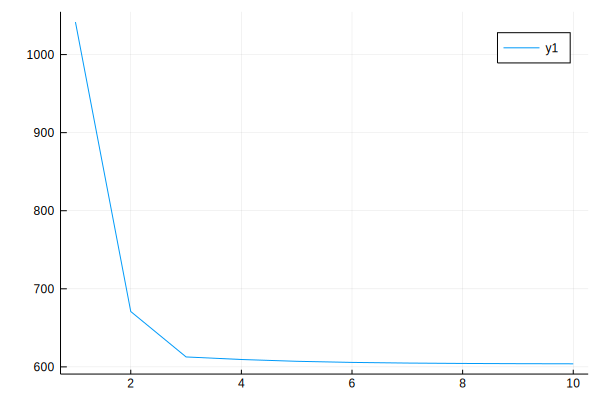

In [48]:
# Single example
plot(sfe[88, :])

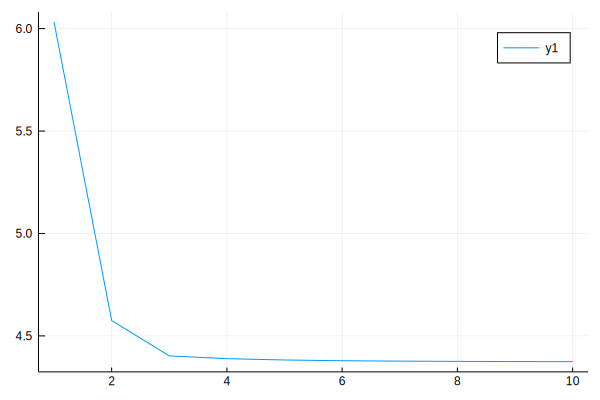

In [49]:
FE = (sum(sfe, dims=1) ./ size(sfe, 1)) ./ 100
plot(FE')

In [50]:
# Time-Varying AR
counter = 0
for i in 1:size(tvfe, 1)
    for j in 2:length(tvfe[i, :])
        if tvfe[i, j] - tvfe[i, j-1] > 1.0
            println("Example #$(i), AR_m = $(length(tvmθ_set[i][1]))")
            counter += 1
            break
        end
    end
end
println(counter)

0


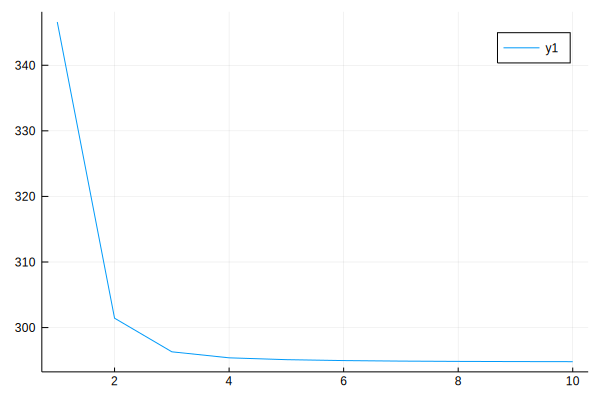

In [51]:
# Single example
plot(tvfe[15, :])

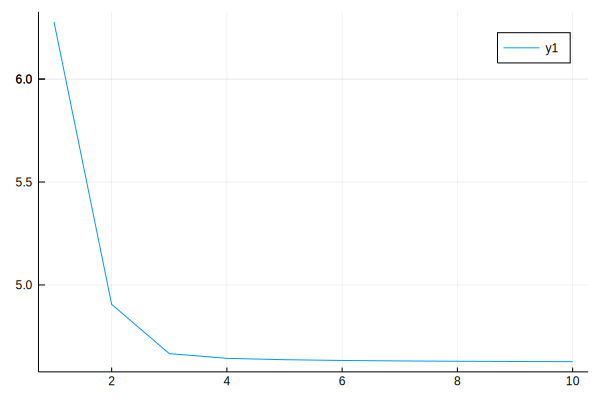

In [52]:
FE = (sum(tvfe, dims=1) ./ size(tvfe, 1)) ./ 100
plot(FE')

In [54]:
sfe

100×10 Array{Float64,2}:
  262.226  244.23   243.797  243.686  …  243.61   243.602  243.597  243.593
  258.466  238.53   236.962  236.15      235.397  235.314  235.26   235.226
  264.842  246.372  245.728  245.511     245.35   245.337  245.329  245.323
  301.628  248.839  244.34   243.352     242.369  242.279  242.228  242.198
  280.773  246.486  242.827  241.923     241.139  241.054  241.002  240.971
  224.028  215.249  214.445  214.019  …  213.538  213.483  213.448  213.426
  248.355  234.733  234.449  234.364     234.282  234.271  234.262  234.255
  242.146  229.952  229.566  229.338     229.044  229.024  229.015  229.01
  250.152  235.867  235.695  235.654     235.586  235.572  235.56   235.551
  252.743  237.048  236.732  236.634     236.535  236.522  236.514  236.509
  397.716  296.686  290.911  290.076  …  289.487  289.451  289.435  289.422
  334.755  291.012  287.821  286.555     285.139  284.922  284.775  284.674
  410.272  283.048  278.782  277.036     275.513  275.375  275.2